In [210]:
import pandas as pd
import numpy as np
import plotly.express as px
import duckdb
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.model_selection import ShuffleSplit

In [211]:
df =  pd.read_csv("./data.csv")

In [212]:
df.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,11/11/07,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,11/11/07,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,11/16/07,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,11/16/07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,11/16/07,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN


In [213]:
df.columns = df.columns.str.lower() \
                        .str.replace(' ', '_') \
                        .str.replace('(', '') \
                        .str.replace(')', '') \
                        .str.replace('/', '_')

In [214]:
df['species'] = df['species'].replace({'Adelie Penguin (Pygoscelis adeliae)': 'Adelie',
                                                'Chinstrap penguin (Pygoscelis antarctica)': 'Chinstrap',
                                                'Gentoo penguin (Pygoscelis papua)': 'Gentoo'})

In [215]:
df.shape

(344, 17)

studyname              0
sample_number          0
species                0
region                 0
island                 0
stage                  0
individual_id          0
clutch_completion      0
date_egg               0
culmen_length_mm       2
culmen_depth_mm        2
flipper_length_mm      2
body_mass_g            2
sex                   10
delta_15_n_o_oo       14
delta_13_c_o_oo       13
comments             318
dtype: int64


<AxesSubplot:>

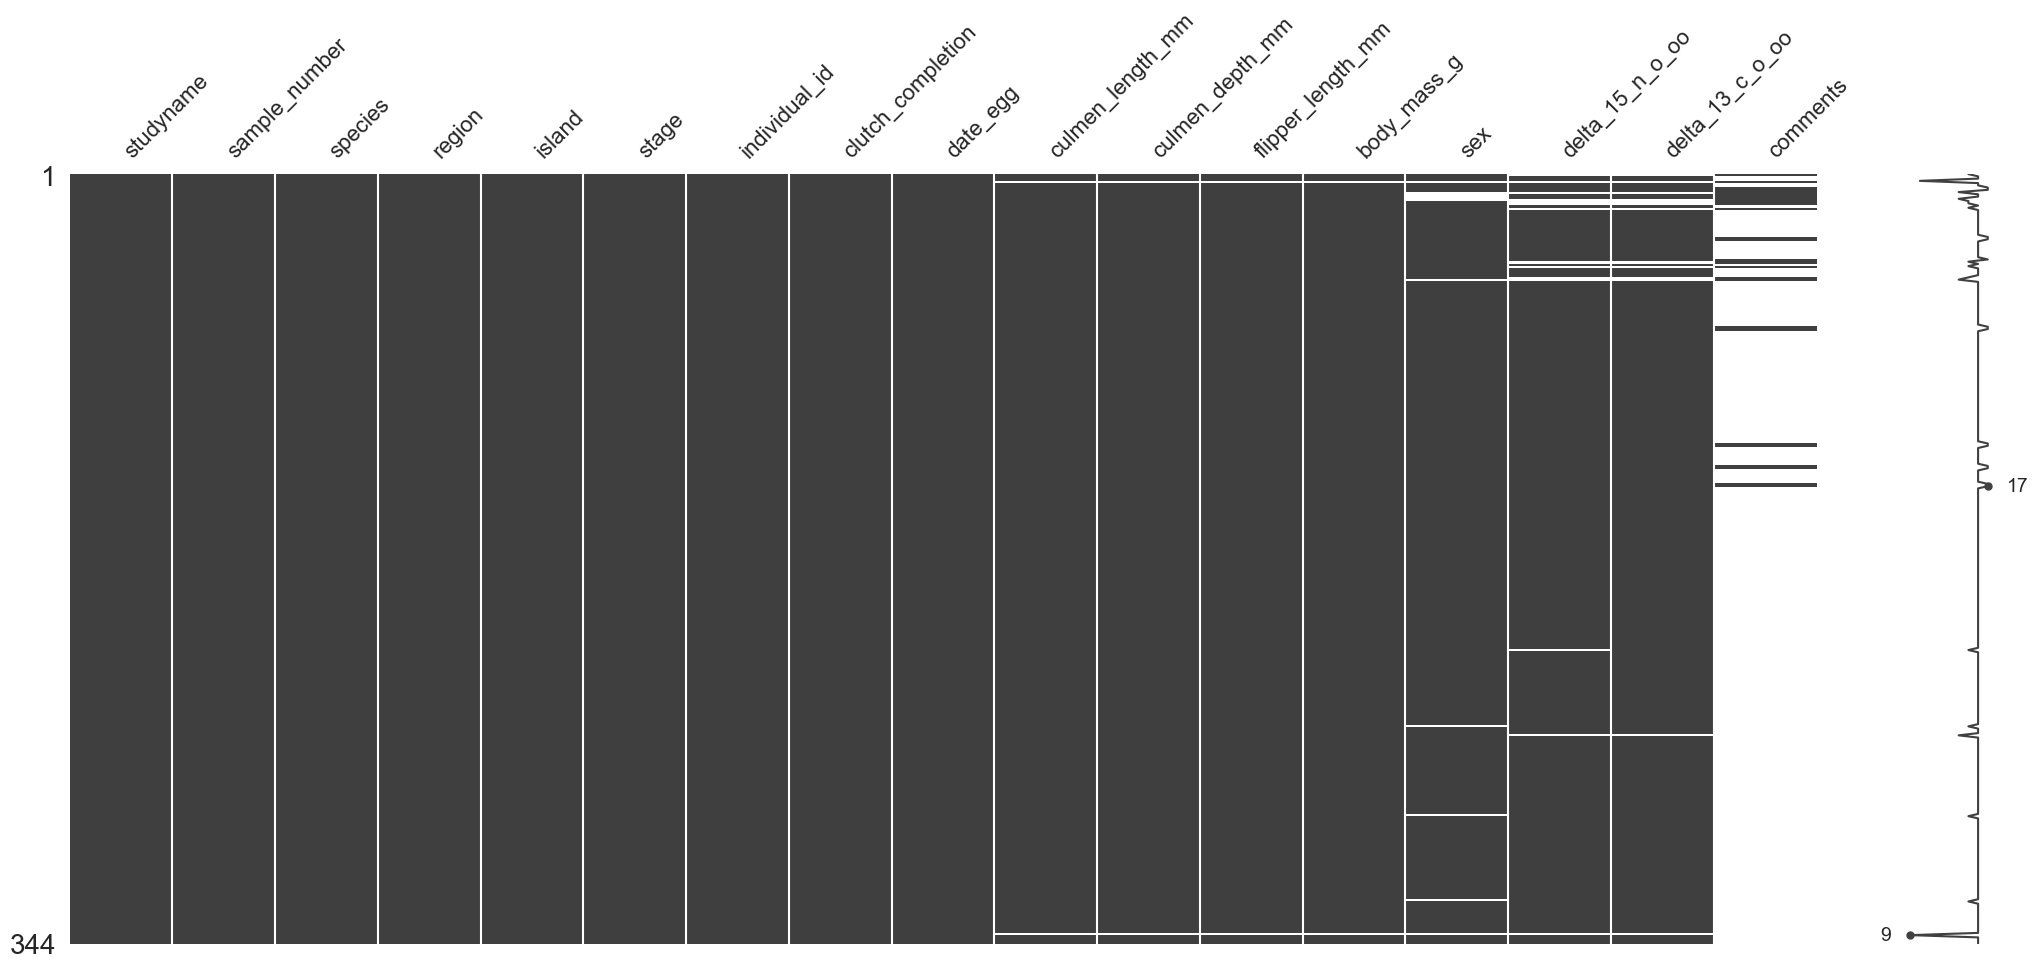

In [216]:
print(df.isna().sum())
msno.matrix(df)
#msno.bar(df) 

In [217]:
#msno.heatmap(df)

#A value near -1 means if one variable appears then the other variable is very likely to be missing.
#A value near 0 means there is no dependence between the occurrence of missing values of two variables.
#A value near 1 means if one variable appears then the other variable is very likely to be present.

In [218]:
study_check = duckdb.query("""SELECT studyname,
                                     species, 
                                     count(species) as nb_penguin 
                                FROM df 
                                GROUP BY studyname, species""").to_df()

study_check.pivot(index='studyname', columns='species')

nb_penguin                 
species       Adelie Chinstrap Gentoo
studyname                            
PAL0708           50        26     34
PAL0809           50        18     46
PAL0910           52        24     44

The species are not balanced in the different studies.

The study itself is not a characteristic of penguins so it shoudn't be used to identify for classification.

We drop this feature.

In [219]:
df.drop(columns=["studyname"], axis=1, inplace=True)

In [220]:
duckdb.query("""SELECT species,
                        count(sample_number),
                        count(distinct sample_number),
                        max(distinct sample_number)
                FROM df 
                GROUP BY species""").to_df()

,species,count(sample_number),count(DISTINCT sample_number),max(DISTINCT sample_number)
0,Adelie,152,152,152
1,Chinstrap,68,68,68
2,Gentoo,124,124,124


The dataset is divided into three samples based on the species. 

For each group of species, the pinguins are numbered.

The feature `sample_number` won't help us in our classification problem so we can drop it.

In [221]:
df.drop(columns=["sample_number"], axis=1, inplace=True)

In [222]:
df

,species,region,island,stage,individual_id,clutch_completion,date_egg,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,delta_15_n_o_oo,delta_13_c_o_oo,comments
0,Adelie,Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,11/11/07,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,Adelie,Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,11/11/07,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,Adelie,Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,11/16/07,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,Adelie,Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,11/16/07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,Adelie,Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,11/16/07,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,Gentoo,Anvers,Biscoe,"Adult, 1 Egg Stage",N38A2,No,12/1/09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Anvers,Biscoe,"Adult, 1 Egg Stage",N39A1,Yes,11/22/09,46.8,14.3,215.0,4850.0,FEMALE,8.41151,-26.13832,NaN
341,Gentoo,Anvers,Biscoe,"Adult, 1 Egg Stage",N39A2,Yes,11/22/09,50.4,15.7,222.0,5750.0,MALE,8.30166,-26.04117,NaN
342,Gentoo,Anvers,Biscoe,"Adult, 1 Egg Stage",N43A1,Yes,11/22/09,45.2,14.8,212.0,5200.0,FEMALE,8.24246,-26.11969,NaN


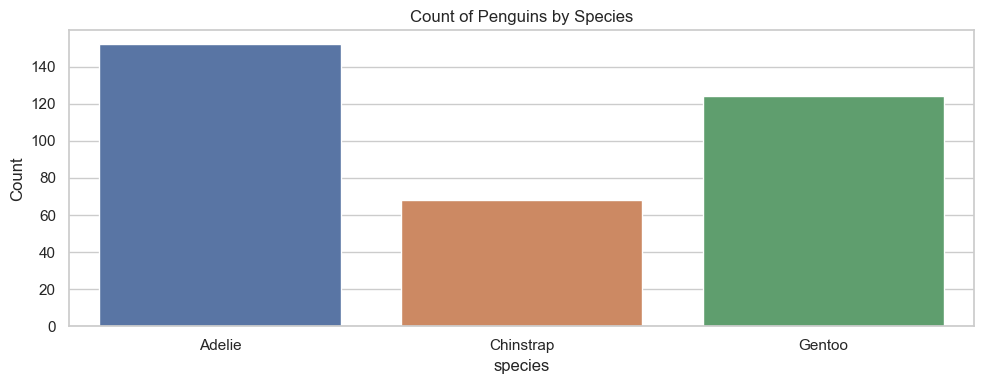

In [223]:
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='species')
plt.title('Count of Penguins by Species')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [224]:
df.species.value_counts()

Adelie       152
Gentoo       124
Chinstrap     68
Name: species, dtype: int64

The classes are not well balanced between each other. This is something to remember during our study.

In [225]:
df.region.value_counts()

Anvers    344
Name: region, dtype: int64

All penguins come from the Anvers region. 

The `region` feature doesn't have any valuable information for penguin classification.

We can drop it.

In [226]:
df.drop(columns=["region"], axis=1, inplace=True)

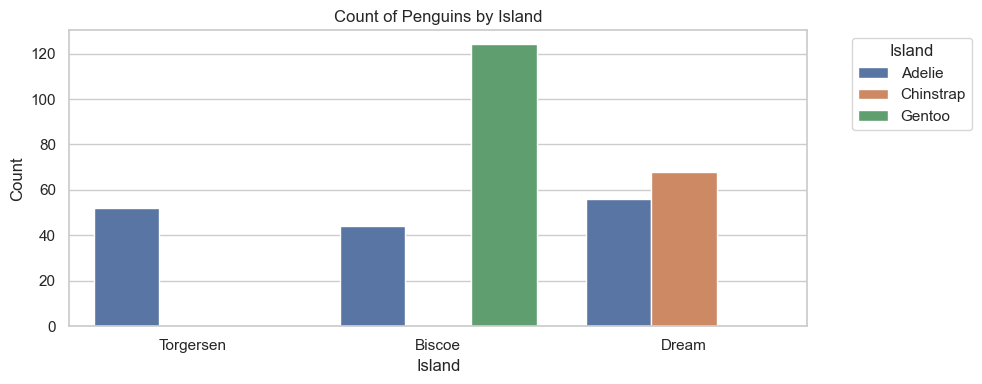

In [227]:
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='island', hue='species')
plt.title('Count of Penguins by Island')
plt.xlabel('Island')
plt.ylabel('Count')
plt.legend(title='Island', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The `island` feature will be very important for our classification.

- from Torgersen, the specie of a penguin is almost certainly Adelie.

- from Biscoe, the specie of a penguin is almost certainly Adelie or Gentoo.

- from Dream, the specie of a penguin is almost certainly Adelie or Chinstrap.

In [228]:
df.stage.value_counts()

Adult, 1 Egg Stage    344
Name: stage, dtype: int64

The feature `stage` also only has one unique value and so it won't be useful for penguin classification.

In [229]:
df.drop(columns=["stage"], axis=1, inplace=True)

In [230]:
print(df.individual_id.nunique())
df.individual_id.value_counts()

190


N61A2    3
N29A2    3
N22A1    3
N22A2    3
N23A1    3
        ..
N10A1    1
N10A2    1
N84A2    1
N84A1    1
N43A2    1
Name: individual_id, Length: 190, dtype: int64

In [231]:
df[df.individual_id == "N61A2"]

,species,island,individual_id,clutch_completion,date_egg,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,delta_15_n_o_oo,delta_13_c_o_oo,comments
115,Adelie,Biscoe,N61A2,Yes,11/17/09,42.7,18.3,196.0,4075.0,MALE,8.91434,-26.42018,NaN
153,Chinstrap,Dream,N61A2,No,11/19/07,50.0,19.5,196.0,3900.0,MALE,8.92069,-24.23592,NaN
179,Chinstrap,Dream,N61A2,No,11/25/08,49.5,19.0,200.0,3800.0,MALE,9.63074,-24.34684,NaN


The feature `individual_id` won't serve us either. Not sure what it indicates but we only have 190 unique IDs and for the same ID we can find often more than 1 penguins that are not even in the same specie.

In [232]:
df.drop(columns=["individual_id"], axis=1, inplace=True)

In [233]:
df.clutch_completion.value_counts()

Yes    308
No      36
Name: clutch_completion, dtype: int64

In [234]:
df

,species,island,clutch_completion,date_egg,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,delta_15_n_o_oo,delta_13_c_o_oo,comments
0,Adelie,Torgersen,Yes,11/11/07,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,Adelie,Torgersen,Yes,11/11/07,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,Adelie,Torgersen,Yes,11/16/07,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,Adelie,Torgersen,Yes,11/16/07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,Adelie,Torgersen,Yes,11/16/07,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,No,12/1/09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,Yes,11/22/09,46.8,14.3,215.0,4850.0,FEMALE,8.41151,-26.13832,NaN
341,Gentoo,Biscoe,Yes,11/22/09,50.4,15.7,222.0,5750.0,MALE,8.30166,-26.04117,NaN
342,Gentoo,Biscoe,Yes,11/22/09,45.2,14.8,212.0,5200.0,FEMALE,8.24246,-26.11969,NaN


In [235]:
clutch_completion = duckdb.query("""SELECT --t1.clutch_completion,
                                        t1.species,
                                        t1.nb as clutch_completion,
                                        t2.nb_total as total_penguins,
                                        (t1.nb/t2.nb_total)*100 as pct_clutch_by_specie,
                                FROM
                                        (SELECT clutch_completion,
                                                species,
                                                count(species) as nb
                                        FROM df 
                                        GROUP BY clutch_completion, species) as t1

                                        LEFT JOIN
                                        (SELECT species,
                                                count(species) as nb_total
                                        FROM df
                                        GROUP BY species) as t2
                                        ON t1.species = t2.species
                                WHERE t1.clutch_completion = 'Yes'
                                """).to_df()

clutch_completion

,species,clutch_completion,total_penguins,pct_clutch_by_specie
0,Adelie,138,152,90.789474
1,Chinstrap,54,68,79.411765
2,Gentoo,116,124,93.548387


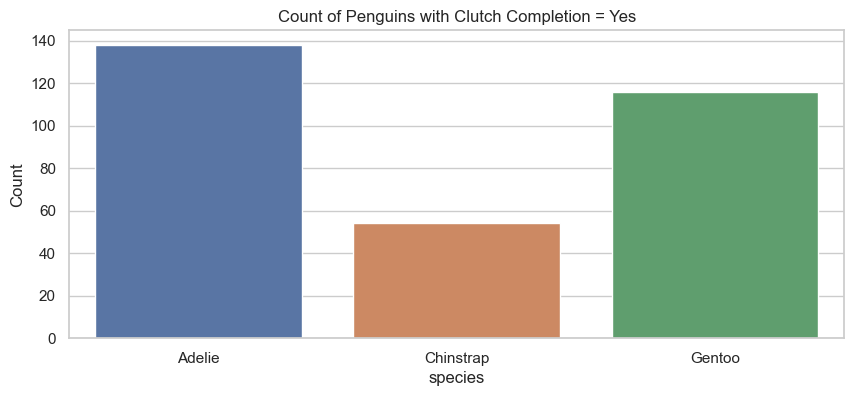

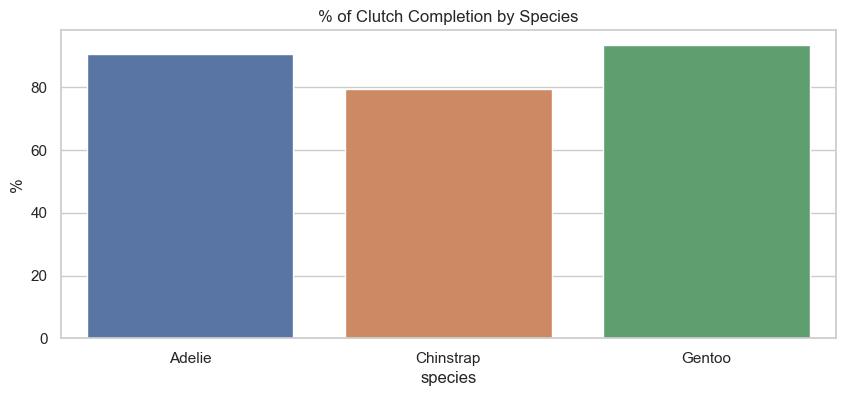

In [236]:
plt.figure(figsize=(10, 4))
sns.barplot(data=clutch_completion, x='species', y = 'clutch_completion')
plt.title('Count of Penguins with Clutch Completion = Yes')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 4))
sns.barplot(data=clutch_completion, x='species', y = 'pct_clutch_by_specie')
plt.title('% of Clutch Completion by Species')
plt.ylabel('%')
plt.show()

We count significantly less `clutch_completion` for the specie Chinstrap but overall we have less of this Specie in our dataset.

This is why we choose to look at the relative `clutch_completion` where we compare the amount `clutch_completion` to the amount of penguins for each species seperatly.

We notice that `clutch_completion` is about the same (90-93%) for the species Adelie and Gentoo but it's about 10% less for the specie Chinstrap.

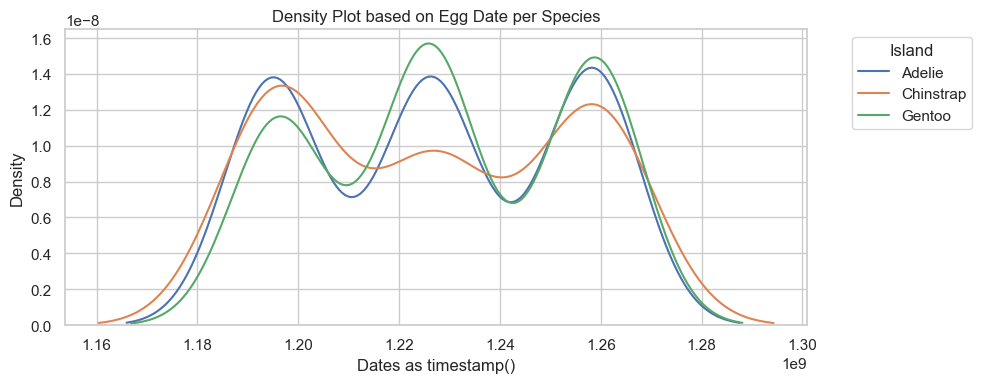

In [261]:
df['date_column'] = pd.to_datetime(df['date_column'])
df['date_egg_numerical'] = df['date_egg'].apply(lambda x: x.timestamp())

plt.figure(figsize=(10, 4))
for species in df['species'].unique():
    sns.kdeplot(data=df[df['species'] == species], x='date_egg_numerical', label=species)
plt.title('Density Plot based on Egg Date per Species')
plt.xlabel('Dates as timestamp()')
plt.legend(title='Island', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

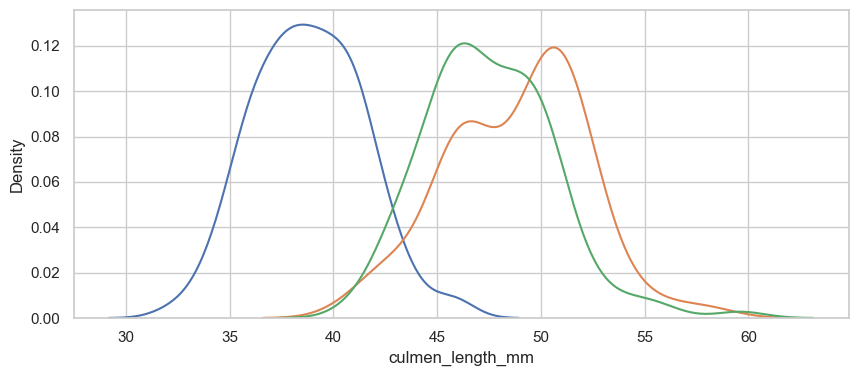

In [263]:
plt.figure(figsize=(10, 4))
for species in df['species'].unique():
    sns.kdeplot(data=df[df['species'] == species], x='culmen_length_mm', label=species)

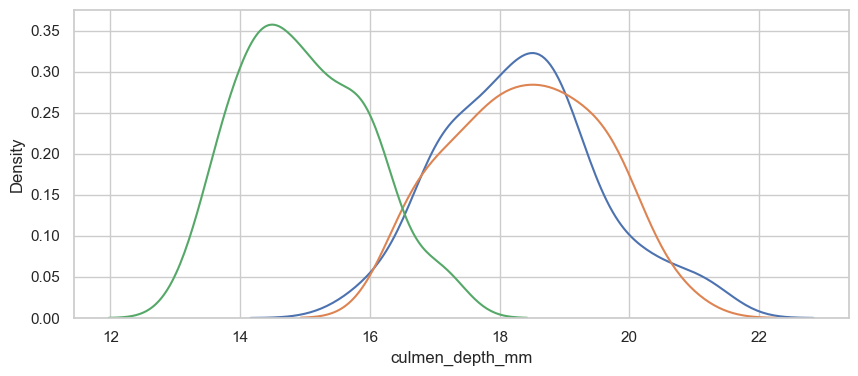

In [266]:
plt.figure(figsize=(10, 4))
for species in df['species'].unique():
    sns.kdeplot(data=df[df['species'] == species], x='culmen_depth_mm', label=species)

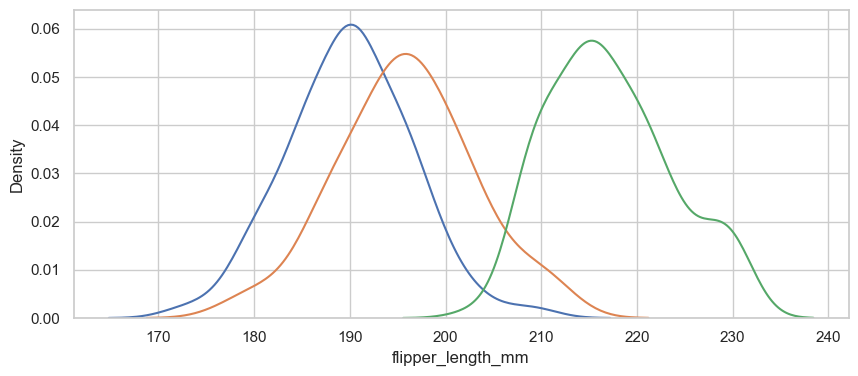

In [267]:
plt.figure(figsize=(10, 4))
for species in df['species'].unique():
    sns.kdeplot(data=df[df['species'] == species], x='flipper_length_mm', label=species)

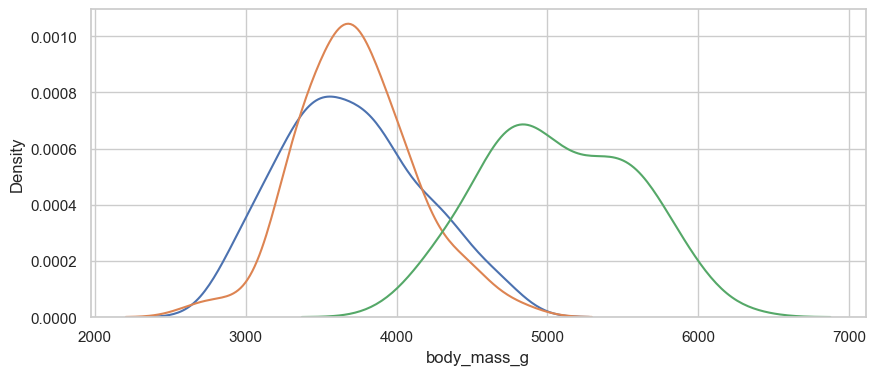

In [268]:
plt.figure(figsize=(10, 4))
for species in df['species'].unique():
    sns.kdeplot(data=df[df['species'] == species], x='body_mass_g', label=species)

In [272]:
duckdb.query("""SELECT species,
                        sex,
                        count(species) as nb_penguins
                FROM df 
                GROUP BY species, sex""").to_df()

,species,sex,nb_penguins
0,Adelie,MALE,73
1,Adelie,FEMALE,73
2,Adelie,NaN,6
3,Chinstrap,FEMALE,34
4,Chinstrap,MALE,34
5,Gentoo,FEMALE,58
6,Gentoo,MALE,61
7,Gentoo,NaN,4
8,Gentoo,.,1


No direct help for the classification but it might help indirectly.

Let's imagine for exemple for some penguins that belong to different species, the feature delta_13_c_o_oo = -25.
If we also know the sex of the animal, it might help us make us conclusion :

-25 + FEMALE might increase the chances that the penguin's specie is A

-25 + MALE might increase the chances that the penguin's specie is B

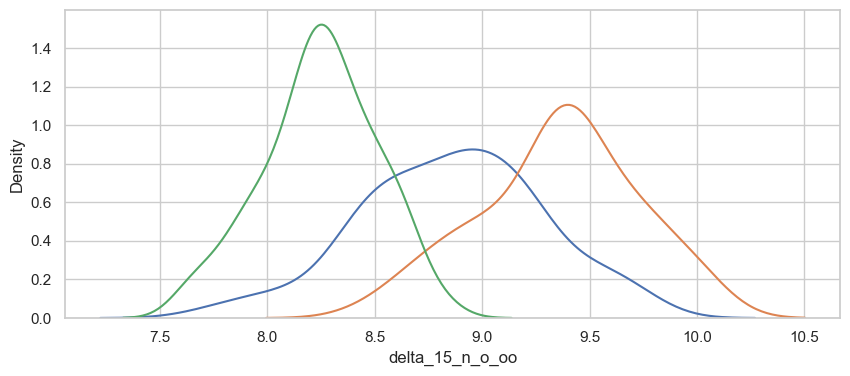

In [273]:
plt.figure(figsize=(10, 4))
for species in df['species'].unique():
    sns.kdeplot(data=df[df['species'] == species], x='delta_15_n_o_oo', label=species)

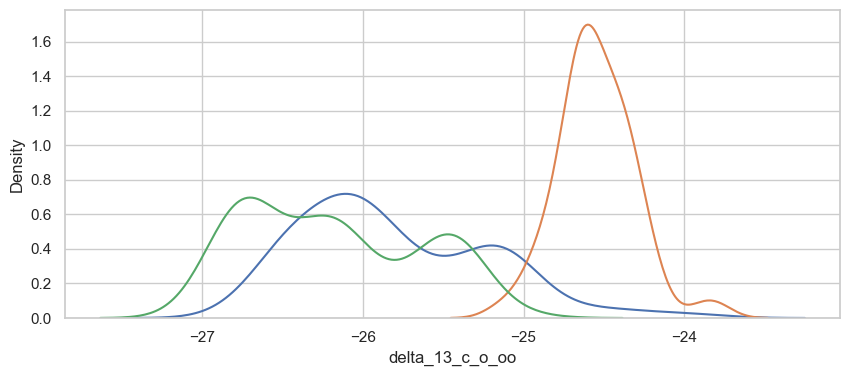

In [274]:
plt.figure(figsize=(10, 4))
for species in df['species'].unique():
    sns.kdeplot(data=df[df['species'] == species], x='delta_13_c_o_oo', label=species)

In [275]:
print(df.comments.value_counts())


Nest never observed with full clutch.                                   13
Not enough blood for isotopes.                                           6
No blood sample obtained.                                                2
No blood sample obtained for sexing.                                     2
Adult not sampled.                                                       1
Nest never observed with full clutch. Not enough blood for isotopes.     1
Sexing primers did not amplify. Not enough blood for isotopes.           1
Name: comments, dtype: int64

In [276]:
df.drop(columns=["comments"], axis=1, inplace=True)

In [277]:
df

,species,island,clutch_completion,date_egg,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,delta_15_n_o_oo,delta_13_c_o_oo,date_egg_numerical
0,Adelie,Torgersen,Yes,2007-11-11,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,1.194739e+09
1,Adelie,Torgersen,Yes,2007-11-11,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,1.194739e+09
2,Adelie,Torgersen,Yes,2007-11-16,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,1.195171e+09
3,Adelie,Torgersen,Yes,2007-11-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.195171e+09
4,Adelie,Torgersen,Yes,2007-11-16,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,1.195171e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,No,2009-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.259626e+09
340,Gentoo,Biscoe,Yes,2009-11-22,46.8,14.3,215.0,4850.0,FEMALE,8.41151,-26.13832,1.258848e+09
341,Gentoo,Biscoe,Yes,2009-11-22,50.4,15.7,222.0,5750.0,MALE,8.30166,-26.04117,1.258848e+09
342,Gentoo,Biscoe,Yes,2009-11-22,45.2,14.8,212.0,5200.0,FEMALE,8.24246,-26.11969,1.258848e+09


In [296]:
def color_cells(val):
    if isinstance(val, (int, float)):
        if val < -0.4:
            return 'background-color: yellow'
        elif val > 0.6:
            return 'background-color: lightgreen'
    return ''

df_corr = pd.DataFrame(df.corr())

lower_triangle_mask = np.tril(np.ones(df_corr.shape), k=-1)
df_corr_triangle = df_corr.where(lower_triangle_mask == 1)

df_corr_triangle.style.applymap(color_cells)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,delta_15_n_o_oo,delta_13_c_o_oo,date_egg_numerical
culmen_length_mm,nan,nan,nan,nan,nan,nan,nan
culmen_depth_mm,-0.235053,nan,nan,nan,nan,nan,nan
flipper_length_mm,0.656181,-0.583851,nan,nan,nan,nan,nan
body_mass_g,0.595110,-0.471916,0.871202,nan,nan,nan,nan
delta_15_n_o_oo,-0.059759,0.605874,-0.507787,-0.537888,nan,nan,nan
delta_13_c_o_oo,0.189025,0.429933,-0.376223,-0.374638,0.570615,nan,nan
date_egg_numerical,0.065303,-0.061845,0.173631,0.044064,0.123058,-0.300234,nan


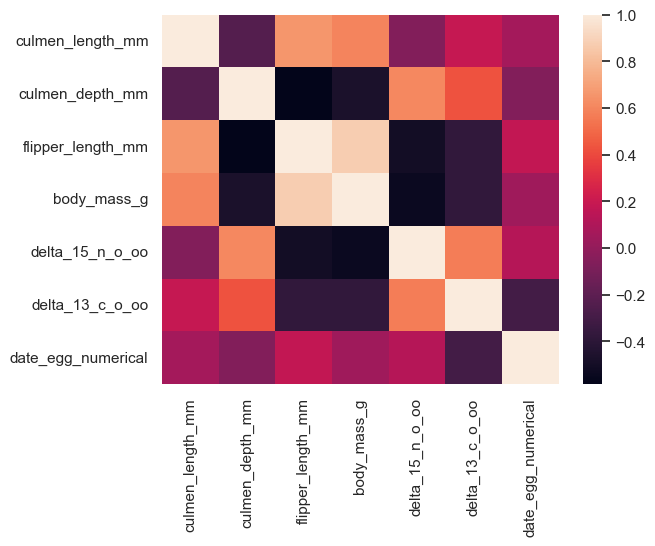

In [282]:
sns.heatmap(df.corr());

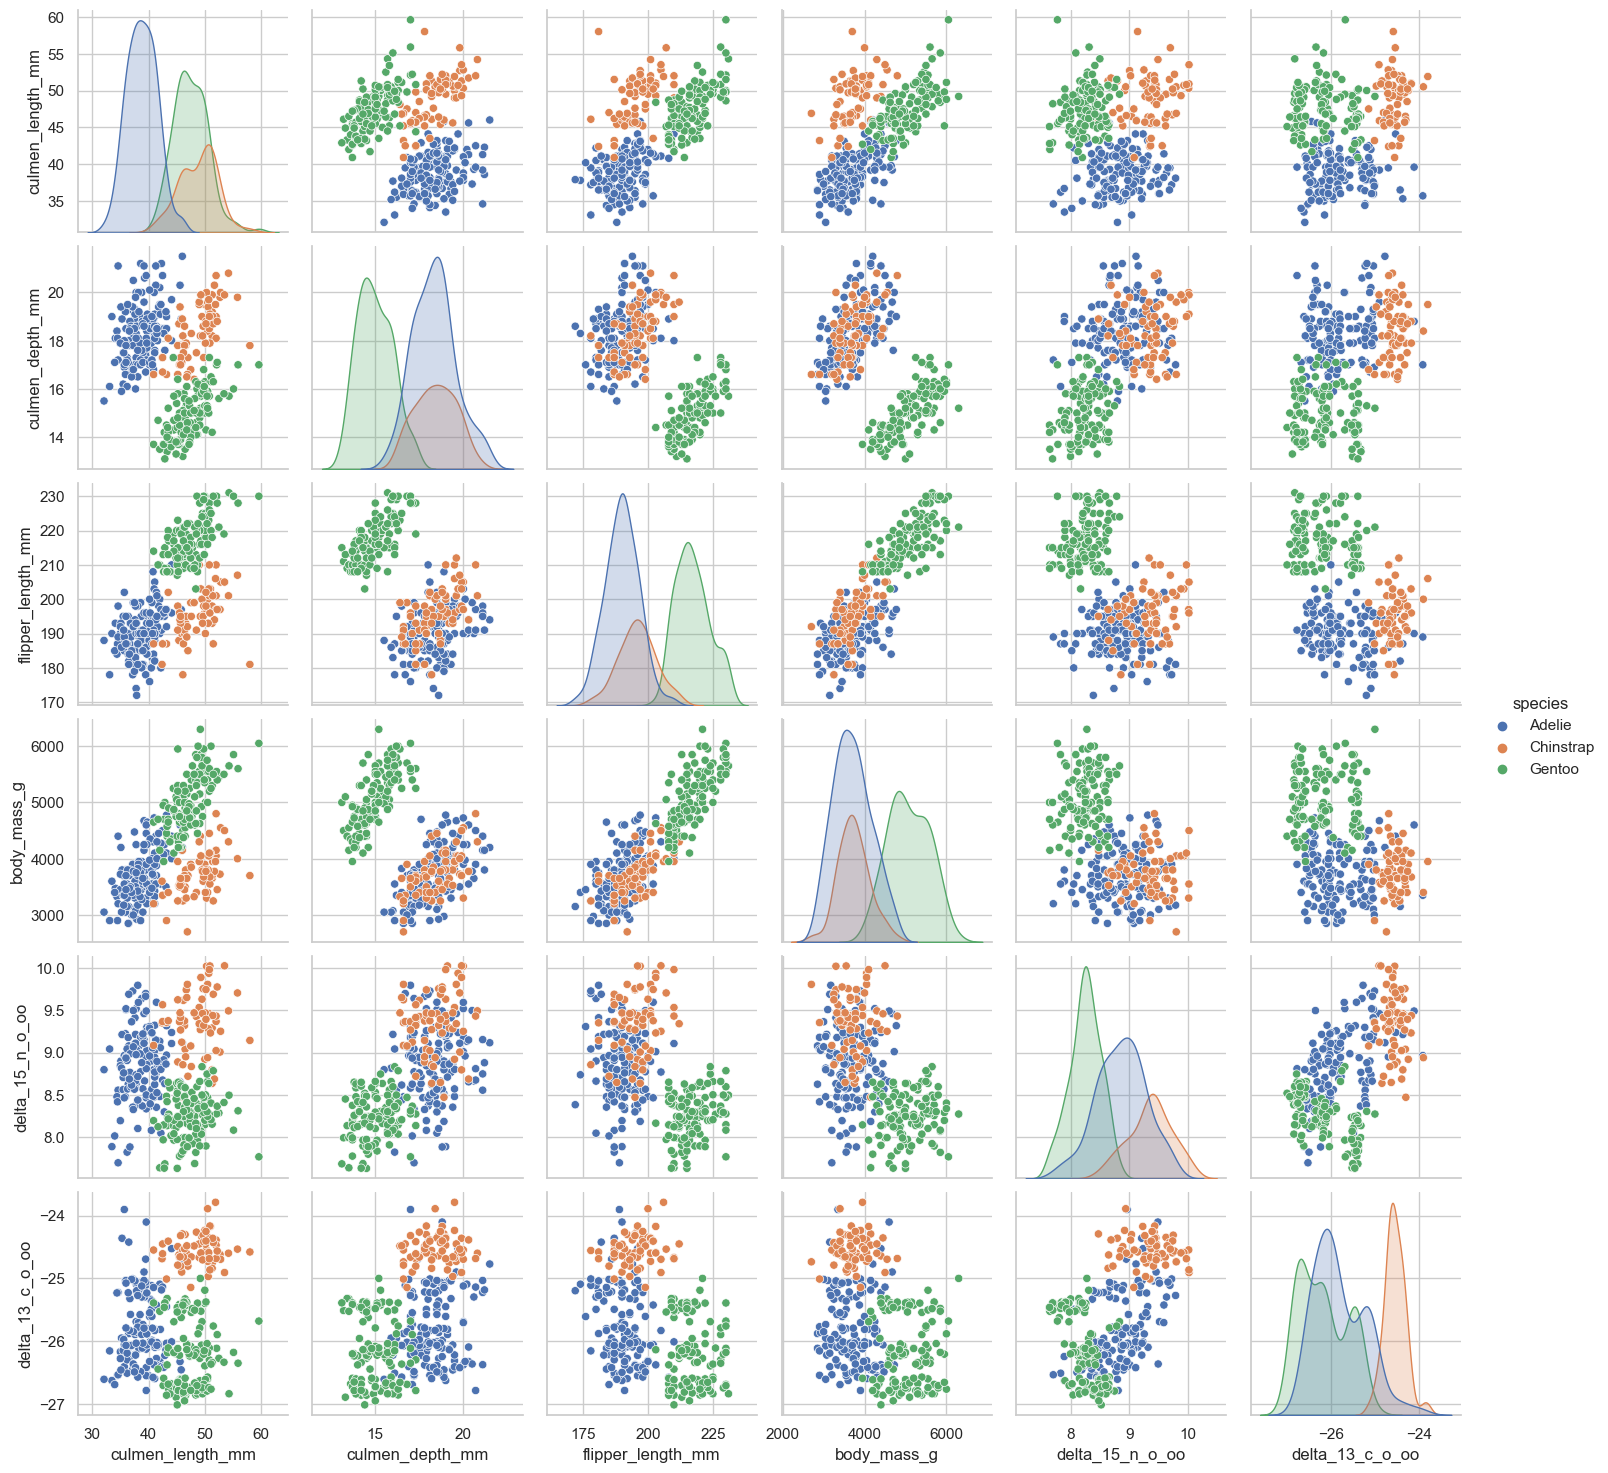

In [299]:
sns.pairplot(df.drop(columns="date_egg_numerical"), hue = "species")
plt.show()